In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X_train = pd.read_csv("X_train.csv").to_numpy()
Y_train = pd.read_csv("Y_train.csv").to_numpy().flatten()  # flatten to 1D for convenience
la = 1
batch_size_list = [10, 20, 50, 100]
step_size_list = [1e-2, 1e-3, 1e-4, 1e-5]
N_epoch = 500
f_star = 57.0410

n_samples, n_features = X_train.shape

for batch_size in batch_size_list:
    n_batches = n_samples // batch_size
    for step_size in step_size_list:
        beta = np.random.randn(n_features)
        b = np.random.randn()
        f = np.zeros(N_epoch)

        for epoch in range(N_epoch):
            perm = np.random.permutation(n_samples)
            X_perm = X_train[perm]
            Y_perm = Y_train[perm]

            for batch_idx in range(n_batches):
                start = batch_idx * batch_size
                end = start + batch_size
                x_batch = X_perm[start:end]
                y_batch = Y_perm[start:end]

                pred = x_batch.dot(beta) + b
                error = pred - y_batch

                grad_beta = (x_batch.T.dot(error) / batch_size) + la * beta
                grad_b = np.sum(error) / batch_size

                beta -= step_size * grad_beta
                b -= step_size * grad_b

            # Compute objective function f at epoch end
            pred_full = X_train.dot(beta) + b
            residual = pred_full - Y_train
            f[epoch] = (np.sum(residual**2) / (2 * n_samples)) + (la / 2) * np.sum(beta**2)

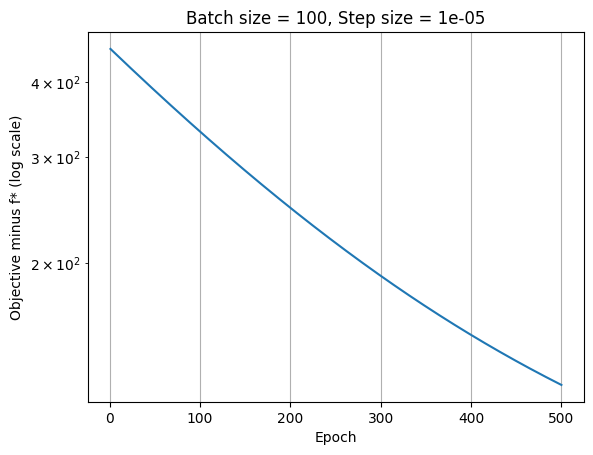

In [ ]:
plt.figure()
plt.semilogy(np.arange(1, N_epoch + 1), f - f_star)
plt.title(f"Batch size = {batch_size}, Step size = {step_size}")
plt.xlabel("Epoch")
plt.ylabel("Objective minus f* (log scale)")
plt.grid(True)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

X_train = pd.read_csv("X_train.csv").to_numpy()
Y_train = pd.read_csv("Y_train.csv").to_numpy().flatten()
la = 0.02
step_size = 0.005
N_epoch = 10000
f_star = 49.9649
groups = [[0], [1], [2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12], [13, 14], [15], [16], [17]]

n_samples, n_features = X_train.shape

# --- Group LASSO ---
beta = np.random.randn(n_features)
b = np.random.randn()
f = np.zeros(N_epoch)

for i in range(N_epoch):
    pred = X_train.dot(beta) + b
    error = pred - Y_train

    grad_beta = (X_train.T.dot(error)) / n_samples
    grad_b = np.sum(error) / n_samples

    beta_prim = beta - step_size * grad_beta

    f[i] = 0  # reset for this iteration
    # Proximal operator for each group
    for group in groups:
        group_vec = beta_prim[group]
        norm_val = np.linalg.norm(group_vec)
        threshold = la * np.sqrt(len(group)) * step_size
        coeff = 1 - threshold / max(norm_val, threshold)
        beta[group] = coeff * group_vec
        f[i] += la * np.sqrt(len(group)) * np.linalg.norm(beta[group])

    f[i] += (np.sum(error**2) / (2 * n_samples))

    b -= step_size * grad_b

plt.figure()
plt.semilogy(np.arange(1, N_epoch + 1), f - f_star)
plt.title(f"Group LASSO, Lambda = {la}, Step size = {step_size}")
plt.xlabel("Epoch")
plt.ylabel("Objective minus f* (log scale)")
plt.grid(True)
plt.savefig(f"Group_LASSO_Lambda_{la}_Step_{step_size}.jpg")
plt.close()

for group in groups:
    print(f"Group {group}: {beta[group]}")

# --- LASSO ---
beta = np.random.randn(n_features)
b = np.random.randn()
f_LASSO = np.zeros(N_epoch)

for i in range(N_epoch):
    pred = X_train.dot(beta) + b
    error = pred - Y_train

    grad_beta = (X_train.T.dot(error)) / n_samples
    grad_b = np.sum(error) / n_samples

    beta_prim = beta - step_size * grad_beta

    norm_val = np.linalg.norm(beta_prim)
    threshold = la * np.sqrt(n_features) * step_size
    coeff = 1 - threshold / max(norm_val, threshold)
    beta = coeff * beta_prim

    f_LASSO[i] = la * np.sqrt(n_features) * np.linalg.norm(beta) + (np.sum(error**2) / (2 * n_samples))

    b -= step_size * grad_b

plt.figure()
plt.semilogy(np.arange(1, N_epoch + 1), f_LASSO - f_star)
plt.title(f"LASSO, Lambda = {la}, Step size = {step_size}")
plt.xlabel("Epoch")
plt.ylabel("Objective minus f* (log scale)")
plt.grid(True)
plt.savefig(f"LASSO_Lambda_{la}_Step_{step_size}.jpg")
plt.close()

print(beta)

# --- Accelerated Group LASSO ---
beta = np.random.randn(n_features)
beta_prev = beta.copy()
b = np.random.randn()
f_acc = np.zeros(N_epoch)

for i in range(N_epoch):
    pred = X_train.dot(beta) + b
    error = pred - Y_train

    grad_beta = (X_train.T.dot(error)) / n_samples
    grad_b = np.sum(error) / n_samples

    momentum = (i - 2) / (i + 1) if i > 0 else 0
    beta_prim = beta - step_size * grad_beta + momentum * (beta - beta_prev)
    beta_prev = beta.copy()

    f_acc[i] = 0
    for group in groups:
        group_vec = beta_prim[group]
        norm_val = np.linalg.norm(group_vec)
        threshold = la * np.sqrt(len(group)) * step_size
        coeff = 1 - threshold / max(norm_val, threshold)
        beta[group] = coeff * group_vec
        f_acc[i] += la * np.sqrt(len(group)) * np.linalg.norm(beta[group])

    f_acc[i] += (np.sum(error**2) / (2 * n_samples))

    b -= step_size * grad_b




Group [0]: [17.93304414]
Group [1]: [-1.54384892]
Group [2, 3, 4, 5, 6]: [-0.00132762 -0.0194062  -0.00112844 -0.00163674 -0.00108234]
Group [7, 8, 9, 10, 11, 12]: [ 0.56522991  0.51478595 -0.4157444  -0.04711256  0.76465943  0.25336224]
Group [13, 14]: [0.72719868 0.26425419]
Group [15]: [6.63970752]
Group [16]: [0.25529313]
Group [17]: [4.88895179]
[15.49283985 -1.6650591  -0.73214874  0.24460137 -1.47359301  2.0681625
  0.14228803  0.7471276   1.16634458 -0.47919631  1.14146974  1.98981994
  0.13888196  0.42937165  1.25638122  6.28452291  0.44203606  3.9489471 ]


Group [0]: [31.36718813]
Group [1]: [-1.43928469]
Group [2, 3, 4, 5, 6]: [-0. -0. -0. -0. -0.]
Group [7, 8, 9, 10, 11, 12]: [-1.78470007e-03 -1.98395196e-03 -2.02928977e-03 -2.09238533e-03
 -9.97237425e-05 -2.02910646e-03]
Group [13, 14]: [-0.  0.]
Group [15]: [9.28827506]
Group [16]: [-10.74568734]
Group [17]: [8.20124381]


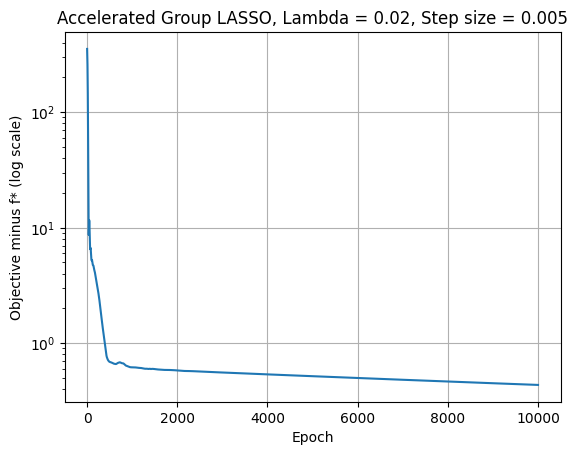

In [ ]:
plt.figure()
plt.semilogy(np.arange(1, N_epoch + 1), f_acc - f_star)
plt.title(f"Accelerated Group LASSO, Lambda = {la}, Step size = {step_size}")
plt.xlabel("Epoch")
plt.ylabel("Objective minus f* (log scale)")
plt.grid(True)
